In [1]:
import numpy as np
import matplotlib.pyplot as plt

import gmplot
import torch
from torch import nn
from tqdm import trange
from sklearn.preprocessing import  OneHotEncoder
import dataLoader
import torchTrain

In [2]:
def draw(list,number,b,k):
    new_list = torch.tensor(list)
    lat = []
    lng = []
    for i in new_list:
        lat.append(i[0])
        lng.append(i[1])
    old_lat = torch.stack(lat[:k-1])
    old_lng =torch.stack(lng[:k-1])
    print(old_lat)
    print(old_lng)
    lat_predict = (lat[k-1:])
    lng_predict = (lng[k-1:])
    print(lat_predict)
    print(lng_predict)
    lat = torch.stack(lat)
    lng =torch.stack(lng)
    gmap = gmplot.GoogleMapPlotter(lat[0], lng[0], b)
    gmap.plot(lat, lng,color='b',lw=20)  #描绘轨迹点
    gmap.plot(lat_predict, lng_predict,color='r',lw=20)  #描绘轨迹点
    gmap.draw("user{}.html".format(number))   #显示图
    print("over")




# 搞一个批量训练的模型

In [3]:


# coincide_number= 0
# coincide = np.zeros(Train_h3_list.size)
#
# #这一段代码验证训练测试集之间数据是否在同一个域内
# print(f"Train_h3_list SIZE : {Train_h3_list.size}")
# print(f"Test_h3_list SIZE : {len(Test_h3_list)}")
# for element in Train_h3_list :
#     if element in Test_h3_list:
#        coincide_number = coincide_number + 1
# print(coincide_number)

train_dataloader,test_dataloader,vocab = dataLoader.DataLoader.load_h3_list()

encoder = OneHotEncoder(sparse=False).fit(vocab.reshape(-1, 1))

#这个函数现在没有用上
def encoding(data):
    return encoder.transform(data.reshape(-1,1))
def decoding(one_hot_data):
    return encoder.inverse_transform(one_hot_data)


# 可以通过idnex找到对应的h3
index_h  = dict(enumerate(vocab))

# 可以通过h3编码找到对应的index
h_index ={h3:i for i ,h3 in index_h.items()}


def label_encode(data):
    return np.array([h_index[ch] for ch in data])
def label_decode(data):
    return np.array([index_h[ch] for ch in data])




In [4]:



# def test_dataloader(y,k):
# 现在相当于是在往前看10步

#暂时不加批量训练
# def data_loader(dataset,batchsize,drop_last=True):
#     for i in range(0,len(dataset)-batchsize+1,batchsize):
#         batch = dataset[i:i+batchsize]
#         batch

In [5]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
class RNN(nn.Module):
    def __init__(self,vocab) -> None:
        super().__init__()
        self.vocab = vocab
        self.num_hiddens = 320
        self.model =nn.LSTM(
            input_size=vocab,
            hidden_size=self.num_hiddens,
            batch_first=True,
            bias=True
        )

        self.output = nn.Sequential(
            nn.Linear(self.num_hiddens,vocab)
        )


    def forward(self,x , state):
        r_out, states= self.model(x.view(1,10,self.vocab) ,state)
        outdata = self.output(r_out[:,-1,:])
        return outdata, states

    def begin_state(self, device, batch_size=1):
        return (torch.zeros((
            self.model.num_layers,
            batch_size, self.num_hiddens), device=device),
                torch.zeros((
                    self.model.num_layers,
                    batch_size, self.num_hiddens), device=device))

net = RNN(len(vocab)).to(device)
# net=nn.DataParallel(net) #这个暂时先别用
optimizer = torch.optim.SGD(net.parameters(),lr = 0.1,momentum=0.8)
optimizer_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
loss_function = nn.CrossEntropyLoss()#输入是没有softmax的，这个函数是自己softmax

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\zhangliyu\.conda\envs\limuconda\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


--------------Epochs100 | 0---------------
average Train Loss : 6.425554547991071 , train acc : 0.07142857142857142


  1%|          | 1/100 [00:16<27:40, 16.77s/it]

test accuracy : 0.05774518790100825 


  2%|▏         | 2/100 [00:27<21:12, 12.99s/it]

--------------Epochs100 | 1---------------
average Train Loss : 5.6789063394288 , train acc : 0.09615384615384616


  3%|▎         | 3/100 [00:37<18:56, 11.72s/it]

--------------Epochs100 | 2---------------
average Train Loss : 5.3882810711424 , train acc : 0.0815018315018315


  4%|▍         | 4/100 [00:47<17:44, 11.09s/it]

--------------Epochs100 | 3---------------
average Train Loss : 5.161163665436127 , train acc : 0.08882783882783883


  5%|▌         | 5/100 [00:57<16:53, 10.67s/it]

--------------Epochs100 | 4---------------
average Train Loss : 4.9999266683837 , train acc : 0.08699633699633699
--------------Epochs100 | 5---------------
average Train Loss : 4.862862723214286 , train acc : 0.08882783882783883


  6%|▌         | 6/100 [01:12<19:00, 12.14s/it]

test accuracy : 0.04307974335472044 


  7%|▋         | 7/100 [01:23<18:08, 11.71s/it]

--------------Epochs100 | 6---------------
average Train Loss : 4.722773848872482 , train acc : 0.09065934065934066


  8%|▊         | 8/100 [01:32<16:59, 11.08s/it]

--------------Epochs100 | 7---------------
average Train Loss : 4.621700971554487 , train acc : 0.09432234432234432


  9%|▉         | 9/100 [01:43<16:43, 11.03s/it]

--------------Epochs100 | 8---------------
average Train Loss : 4.7561607500572345 , train acc : 0.09706959706959707


 10%|█         | 10/100 [01:54<16:15, 10.83s/it]

--------------Epochs100 | 9---------------
average Train Loss : 4.542042267628205 , train acc : 0.09340659340659341
--------------Epochs100 | 10---------------
average Train Loss : 4.612991947830815 , train acc : 0.09798534798534798


 11%|█         | 11/100 [02:10<18:36, 12.54s/it]

test accuracy : 0.051329055912007336 


 12%|█▏        | 12/100 [02:20<17:16, 11.78s/it]

--------------Epochs100 | 11---------------
average Train Loss : 4.612779107285943 , train acc : 0.08791208791208792


 13%|█▎        | 13/100 [02:30<16:23, 11.30s/it]

--------------Epochs100 | 12---------------
average Train Loss : 4.553658621651786 , train acc : 0.0989010989010989


 14%|█▍        | 14/100 [02:40<15:40, 10.94s/it]

--------------Epochs100 | 13---------------
average Train Loss : 4.5901983351934526 , train acc : 0.09523809523809523


 15%|█▌        | 15/100 [02:51<15:07, 10.67s/it]

--------------Epochs100 | 14---------------
average Train Loss : 4.6046893780048075 , train acc : 0.09706959706959707
--------------Epochs100 | 15---------------
average Train Loss : 4.433463631095467 , train acc : 0.09706959706959707


 16%|█▌        | 16/100 [03:06<16:52, 12.06s/it]

test accuracy : 0.03666361136571952 


 17%|█▋        | 17/100 [03:16<15:52, 11.47s/it]

--------------Epochs100 | 16---------------
average Train Loss : 4.676798055460165 , train acc : 0.11172161172161173


 18%|█▊        | 18/100 [03:26<15:05, 11.04s/it]

--------------Epochs100 | 17---------------
average Train Loss : 4.365677494705815 , train acc : 0.10989010989010989


 19%|█▉        | 19/100 [03:36<14:35, 10.81s/it]

--------------Epochs100 | 18---------------
average Train Loss : 4.495657784598214 , train acc : 0.09981684981684982


 20%|██        | 20/100 [03:46<14:03, 10.55s/it]

--------------Epochs100 | 19---------------
average Train Loss : 4.261131649925595 , train acc : 0.12087912087912088
--------------Epochs100 | 20---------------
average Train Loss : 4.178969386733058 , train acc : 0.12087912087912088


 21%|██        | 21/100 [04:02<16:09, 12.27s/it]

test accuracy : 0.054995417048579284 


 22%|██▏       | 22/100 [04:12<14:58, 11.51s/it]

--------------Epochs100 | 21---------------
average Train Loss : 3.893327091203068 , train acc : 0.13553113553113552


 23%|██▎       | 23/100 [04:22<14:00, 10.91s/it]

--------------Epochs100 | 22---------------
average Train Loss : 3.8657052176339284 , train acc : 0.1346153846153846


 24%|██▍       | 24/100 [04:31<13:19, 10.52s/it]

--------------Epochs100 | 23---------------
average Train Loss : 3.8849426940247254 , train acc : 0.13095238095238096


 25%|██▌       | 25/100 [04:41<12:58, 10.38s/it]

--------------Epochs100 | 24---------------
average Train Loss : 3.7317940848214284 , train acc : 0.13644688644688643
--------------Epochs100 | 25---------------
average Train Loss : 3.5636733058608057 , train acc : 0.1382783882783883


 26%|██▌       | 26/100 [04:57<14:54, 12.09s/it]

test accuracy : 0.054995417048579284 


 27%|██▋       | 27/100 [05:08<14:11, 11.66s/it]

--------------Epochs100 | 26---------------
average Train Loss : 3.417748308007097 , train acc : 0.15934065934065933


 28%|██▊       | 28/100 [05:19<13:48, 11.51s/it]

--------------Epochs100 | 27---------------
average Train Loss : 3.2625638521634617 , train acc : 0.16483516483516483


 29%|██▉       | 29/100 [05:29<12:59, 10.98s/it]

--------------Epochs100 | 28---------------
average Train Loss : 3.148371322687729 , train acc : 0.18406593406593408


 30%|███       | 30/100 [05:39<12:19, 10.57s/it]

--------------Epochs100 | 29---------------
average Train Loss : 2.9949964586195055 , train acc : 0.20146520146520147
--------------Epochs100 | 30---------------
average Train Loss : 2.939707773509043 , train acc : 0.1858974358974359


 31%|███       | 31/100 [05:53<13:33, 11.79s/it]

test accuracy : 0.03941338221814849 


 32%|███▏      | 32/100 [06:03<12:36, 11.13s/it]

--------------Epochs100 | 31---------------
average Train Loss : 2.875870589371566 , train acc : 0.19047619047619047


 33%|███▎      | 33/100 [06:12<11:53, 10.65s/it]

--------------Epochs100 | 32---------------
average Train Loss : 2.9011856470352564 , train acc : 0.2216117216117216


 34%|███▍      | 34/100 [06:22<11:21, 10.33s/it]

--------------Epochs100 | 33---------------
average Train Loss : 2.518183334406479 , train acc : 0.2600732600732601


 35%|███▌      | 35/100 [06:32<10:56, 10.10s/it]

--------------Epochs100 | 34---------------
average Train Loss : 2.319489531464629 , train acc : 0.2683150183150183
--------------Epochs100 | 35---------------
average Train Loss : 2.319714668469551 , train acc : 0.29945054945054944


 36%|███▌      | 36/100 [06:46<12:12, 11.45s/it]

test accuracy : 0.03391384051329056 


 37%|███▋      | 37/100 [06:56<11:26, 10.90s/it]

--------------Epochs100 | 36---------------
average Train Loss : 2.3264419499771063 , train acc : 0.2802197802197802


 38%|███▊      | 38/100 [07:05<10:50, 10.49s/it]

--------------Epochs100 | 37---------------
average Train Loss : 2.1822664030305634 , train acc : 0.3305860805860806


 39%|███▉      | 39/100 [07:15<10:24, 10.24s/it]

--------------Epochs100 | 38---------------
average Train Loss : 1.9674915132068453 , train acc : 0.3553113553113553


 40%|████      | 40/100 [07:24<10:01, 10.02s/it]

--------------Epochs100 | 39---------------
average Train Loss : 2.1673912635216346 , train acc : 0.33974358974358976
--------------Epochs100 | 40---------------
average Train Loss : 1.8864285535428114 , train acc : 0.38553113553113555


 41%|████      | 41/100 [07:39<11:09, 11.35s/it]

test accuracy : 0.04674610449129239 


 42%|████▏     | 42/100 [07:48<10:26, 10.80s/it]

--------------Epochs100 | 41---------------
average Train Loss : 1.8167769323775182 , train acc : 0.41025641025641024


 43%|████▎     | 43/100 [07:58<09:54, 10.42s/it]

--------------Epochs100 | 42---------------
average Train Loss : 1.5742379771920787 , train acc : 0.4478021978021978


 44%|████▍     | 44/100 [08:08<09:30, 10.19s/it]

--------------Epochs100 | 43---------------
average Train Loss : 1.4218221252217835 , train acc : 0.4734432234432234


 45%|████▌     | 45/100 [08:17<09:09,  9.98s/it]

--------------Epochs100 | 44---------------
average Train Loss : 1.4044613122066736 , train acc : 0.48717948717948717
--------------Epochs100 | 45---------------
average Train Loss : 1.2471026186541323 , train acc : 0.5164835164835165


 46%|████▌     | 46/100 [08:32<10:14, 11.38s/it]

test accuracy : 0.07241063244729606 


 47%|████▋     | 47/100 [08:41<09:37, 10.89s/it]

--------------Epochs100 | 46---------------
average Train Loss : 1.1119917984847183 , train acc : 0.554945054945055


 48%|████▊     | 48/100 [08:52<09:15, 10.68s/it]

--------------Epochs100 | 47---------------
average Train Loss : 1.0236375969408196 , train acc : 0.5677655677655677


 49%|████▉     | 49/100 [09:02<08:51, 10.43s/it]

--------------Epochs100 | 48---------------
average Train Loss : 0.9265208261790293 , train acc : 0.5943223443223443


 50%|█████     | 50/100 [09:12<08:42, 10.44s/it]

--------------Epochs100 | 49---------------
average Train Loss : 0.8996500427469666 , train acc : 0.6336996336996337
--------------Epochs100 | 50---------------
average Train Loss : 0.9717721345223786 , train acc : 0.597985347985348


 51%|█████     | 51/100 [09:28<09:50, 12.06s/it]

test accuracy : 0.10265811182401467 


 52%|█████▏    | 52/100 [09:37<09:03, 11.33s/it]

--------------Epochs100 | 51---------------
average Train Loss : 0.8966641268887363 , train acc : 0.6144688644688645


 53%|█████▎    | 53/100 [09:47<08:28, 10.82s/it]

--------------Epochs100 | 52---------------
average Train Loss : 0.915969736846812 , train acc : 0.5998168498168498


 54%|█████▍    | 54/100 [09:57<08:02, 10.49s/it]

--------------Epochs100 | 53---------------
average Train Loss : 1.1024970309638278 , train acc : 0.5686813186813187


 55%|█████▌    | 55/100 [10:07<07:42, 10.27s/it]

--------------Epochs100 | 54---------------
average Train Loss : 1.0933686979524382 , train acc : 0.5402930402930403
--------------Epochs100 | 55---------------
average Train Loss : 0.9482684572101076 , train acc : 0.5989010989010989


 56%|█████▌    | 56/100 [10:23<08:51, 12.08s/it]

test accuracy : 0.076993583868011 


 57%|█████▋    | 57/100 [10:33<08:17, 11.57s/it]

--------------Epochs100 | 56---------------
average Train Loss : 0.8366294553428343 , train acc : 0.6465201465201466


 58%|█████▊    | 58/100 [10:43<07:43, 11.04s/it]

--------------Epochs100 | 57---------------
average Train Loss : 0.7102542080722012 , train acc : 0.6694139194139194


 59%|█████▉    | 59/100 [10:53<07:24, 10.84s/it]

--------------Epochs100 | 58---------------
average Train Loss : 0.6689969576322116 , train acc : 0.6776556776556777


 60%|██████    | 60/100 [11:04<07:05, 10.63s/it]

--------------Epochs100 | 59---------------
average Train Loss : 0.5593868157802484 , train acc : 0.728021978021978
--------------Epochs100 | 60---------------
average Train Loss : 0.46017447670737466 , train acc : 0.7710622710622711


 61%|██████    | 61/100 [11:19<07:46, 11.97s/it]

test accuracy : 0.12740604949587533 


 62%|██████▏   | 62/100 [11:29<07:20, 11.59s/it]

--------------Epochs100 | 61---------------
average Train Loss : 0.3900901319343092 , train acc : 0.7847985347985348


 63%|██████▎   | 63/100 [11:39<06:50, 11.10s/it]

--------------Epochs100 | 62---------------
average Train Loss : 0.35458958105289895 , train acc : 0.7921245421245421


 64%|██████▍   | 64/100 [11:50<06:36, 11.01s/it]

--------------Epochs100 | 63---------------
average Train Loss : 0.33904691144223614 , train acc : 0.7939560439560439


 65%|██████▌   | 65/100 [12:01<06:19, 10.83s/it]

--------------Epochs100 | 64---------------
average Train Loss : 0.3351442665407509 , train acc : 0.7985347985347986
--------------Epochs100 | 65---------------
average Train Loss : 0.33583831787109375 , train acc : 0.8122710622710623


 66%|██████▌   | 66/100 [12:16<06:54, 12.18s/it]

test accuracy : 0.1759853345554537 


 67%|██████▋   | 67/100 [12:26<06:23, 11.61s/it]

--------------Epochs100 | 66---------------
average Train Loss : 0.35510063870049224 , train acc : 0.8012820512820513


 68%|██████▊   | 68/100 [12:37<06:01, 11.29s/it]

--------------Epochs100 | 67---------------
average Train Loss : 0.36304065858051454 , train acc : 0.8003663003663004


 69%|██████▉   | 69/100 [12:47<05:42, 11.06s/it]

--------------Epochs100 | 68---------------
average Train Loss : 0.37550753638857887 , train acc : 0.793040293040293


 70%|███████   | 70/100 [12:59<05:36, 11.21s/it]

--------------Epochs100 | 69---------------
average Train Loss : 0.3465189392313416 , train acc : 0.8205128205128205
--------------Epochs100 | 70---------------
average Train Loss : 0.32616813016898466 , train acc : 0.826007326007326


 71%|███████   | 71/100 [13:14<05:57, 12.32s/it]

test accuracy : 0.11090742438130156 


 72%|███████▏  | 72/100 [13:23<05:22, 11.53s/it]

--------------Epochs100 | 71---------------
average Train Loss : 0.28929845230046647 , train acc : 0.8195970695970696


 73%|███████▎  | 73/100 [13:33<04:56, 10.97s/it]

--------------Epochs100 | 72---------------
average Train Loss : 0.242259518130795 , train acc : 0.8489010989010989


 74%|███████▍  | 74/100 [13:43<04:34, 10.54s/it]

--------------Epochs100 | 73---------------
average Train Loss : 0.2049641591725332 , train acc : 0.8681318681318682


 75%|███████▌  | 75/100 [13:52<04:17, 10.30s/it]

--------------Epochs100 | 74---------------
average Train Loss : 0.19519058339325063 , train acc : 0.8754578754578755
--------------Epochs100 | 75---------------
average Train Loss : 0.17079463022532482 , train acc : 0.8763736263736264


 76%|███████▌  | 76/100 [14:07<04:40, 11.69s/it]

test accuracy : 0.15490375802016498 


 77%|███████▋  | 77/100 [14:17<04:18, 11.25s/it]

--------------Epochs100 | 76---------------
average Train Loss : 0.14591859810518257 , train acc : 0.8983516483516484


 78%|███████▊  | 78/100 [14:28<04:04, 11.13s/it]

--------------Epochs100 | 77---------------
average Train Loss : 0.13336301810575493 , train acc : 0.9056776556776557


 79%|███████▉  | 79/100 [14:40<03:55, 11.20s/it]

--------------Epochs100 | 78---------------
average Train Loss : 0.12094001630287031 , train acc : 0.9038461538461539


 80%|████████  | 80/100 [14:50<03:39, 10.99s/it]

--------------Epochs100 | 79---------------
average Train Loss : 0.11114815652588785 , train acc : 0.9230769230769231
--------------Epochs100 | 80---------------
average Train Loss : 0.10302295614948202 , train acc : 0.9221611721611722


 81%|████████  | 81/100 [15:07<04:02, 12.78s/it]

test accuracy : 0.12557286892758937 


 82%|████████▏ | 82/100 [15:18<03:41, 12.32s/it]

--------------Epochs100 | 81---------------
average Train Loss : 0.09854585696489383 , train acc : 0.9294871794871795


 83%|████████▎ | 83/100 [15:30<03:24, 12.04s/it]

--------------Epochs100 | 82---------------
average Train Loss : 0.09503247886350304 , train acc : 0.9423076923076923


 84%|████████▍ | 84/100 [15:40<03:04, 11.54s/it]

--------------Epochs100 | 83---------------
average Train Loss : 0.09247508066477793 , train acc : 0.9395604395604396


 85%|████████▌ | 85/100 [15:51<02:50, 11.35s/it]

--------------Epochs100 | 84---------------
average Train Loss : 0.08964607741806534 , train acc : 0.9423076923076923
--------------Epochs100 | 85---------------
average Train Loss : 0.08738756703806448 , train acc : 0.9368131868131868


 86%|████████▌ | 86/100 [16:07<02:59, 12.81s/it]

test accuracy : 0.13657195233730524 


 87%|████████▋ | 87/100 [16:17<02:34, 11.87s/it]

--------------Epochs100 | 86---------------
average Train Loss : 0.08502763880914821 , train acc : 0.9304029304029304


 88%|████████▊ | 88/100 [16:27<02:16, 11.34s/it]

--------------Epochs100 | 87---------------
average Train Loss : 0.08208460685534355 , train acc : 0.9322344322344323


 89%|████████▉ | 89/100 [16:38<02:03, 11.23s/it]

--------------Epochs100 | 88---------------
average Train Loss : 0.08176603771391369 , train acc : 0.9413919413919414


 90%|█████████ | 90/100 [16:48<01:49, 10.98s/it]

--------------Epochs100 | 89---------------
average Train Loss : 0.07767594864953568 , train acc : 0.9413919413919414
--------------Epochs100 | 90---------------
average Train Loss : 0.07638711894388164 , train acc : 0.9505494505494505


 91%|█████████ | 91/100 [17:05<01:52, 12.54s/it]

test accuracy : 0.12648945921173235 


 92%|█████████▏| 92/100 [17:15<01:35, 11.96s/it]

--------------Epochs100 | 91---------------
average Train Loss : 0.07358850751604352 , train acc : 0.9331501831501832


 93%|█████████▎| 93/100 [17:25<01:19, 11.31s/it]

--------------Epochs100 | 92---------------
average Train Loss : 0.07179341298756582 , train acc : 0.9404761904761905


 94%|█████████▍| 94/100 [17:35<01:05, 10.88s/it]

--------------Epochs100 | 93---------------
average Train Loss : 0.06992986350705772 , train acc : 0.9386446886446886


 95%|█████████▌| 95/100 [17:45<00:52, 10.59s/it]

--------------Epochs100 | 94---------------
average Train Loss : 0.06840084061954484 , train acc : 0.9542124542124543
--------------Epochs100 | 95---------------
average Train Loss : 0.0662244160970052 , train acc : 0.9478021978021978


 96%|█████████▌| 96/100 [18:00<00:47, 11.97s/it]

test accuracy : 0.11274060494958753 


 97%|█████████▋| 97/100 [18:10<00:33, 11.32s/it]

--------------Epochs100 | 96---------------
average Train Loss : 0.06481034415108818 , train acc : 0.9395604395604396


 98%|█████████▊| 98/100 [18:20<00:21, 10.86s/it]

--------------Epochs100 | 97---------------
average Train Loss : 0.06556555639693151 , train acc : 0.9532967032967034


 99%|█████████▉| 99/100 [18:30<00:10, 10.60s/it]

--------------Epochs100 | 98---------------
average Train Loss : 0.0652032929025727 , train acc : 0.9487179487179487


100%|██████████| 100/100 [18:39<00:00, 11.20s/it]

--------------Epochs100 | 99---------------
average Train Loss : 0.06601611685840202 , train acc : 0.9496336996336996


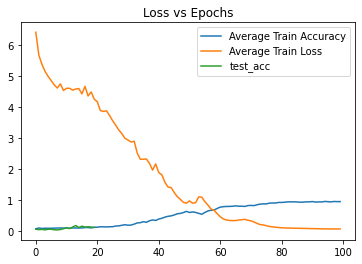

In [6]:


top_k = 5

epoches = 100



train_acc = []
train_loss = []
test_acc = []


for epoch in trange(epoches):


    optimizer_scheduler.step()
    optimizer.step()

    how_many_instance, loss_, how_many_instance_right = torchTrain.train_epoch(net,train_dataloader,loss_function,optimizer,device,top_k,label_decode,label_encode,encoder)

    train_loss.append(loss_.cpu().detach().numpy() / how_many_instance)
    train_acc.append(how_many_instance_right / how_many_instance)
    print(f'--------------Epochs{epoches} | {epoch}---------------')
    print(f'average Train Loss : {train_loss[-1]} , train acc : {train_acc[-1]}')

    if epoch%5 == 0:
        how_many_instance, how_many_instance_right, predict_answer_list = torchTrain.predict_epoch(net,test_dataloader,device,top_k,label_decode,encoder)

        test_acc.append(how_many_instance_right / how_many_instance )
        print(f'test accuracy : { test_acc[-1]} ')


plt.plot(train_acc, label='Average Train Accuracy')
plt.plot(train_loss, label='Average Train Loss')
plt.plot(test_acc, label='test_acc')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()






In [7]:
top_k = 5
name_id = 1
how_many_instance, how_many_instance_right, predict_answer_list = torchTrain.predict_epoch(net,test_dataloader,device,top_k,label_decode,encoder)
predict_answer_geo_list = dataLoader.h3_t_geo(predict_answer_list)
# old=h3_t_geo(i.tolist())
# total_list = old+predict
# print(total_list)
draw(predict_answer_geo_list,name_id,20,10)
name_id+=1

print(predict_answer_list)

torch.save(net,"model_2022_4_8.pt")

TypeError: Argument 'h' has incorrect type (expected str, got numpy.ndarray)